# Decision Tree Data Mining

We'll get some practice on the "Titanic" dataset, which is one of the [introductory examples on Kaggle](https://www.kaggle.com/c/titanic). Alexander pulled a copy from [Chris Piech's CS109 course](https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/problem12.html) and included it in the `data/` directory at the base of this repository.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
# Note: assumes `graphviz` is installed (pip install graphviz) which *probably* requires `libgraphviz-dev`

We'll load in a copy of the titanic dataset:

In [2]:
df = pd.read_csv("../data/titanic.csv")

df

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


## Should we trust this dataset?

https://en.wikipedia.org/wiki/Passengers_of_the_Titanic

We'll check a few things to make some visualization and modeling easier later. The "Sex" column appears to list male or female:

In [3]:
df.Sex.unique()

array(['male', 'female'], dtype=object)

Our uniqueness check shows that indeed this only contains `male` and `female` entries. We'll re-encode these in an ordinal representation, somewhat arbitrarily choosing that `male=0` and `female=1`.

In [4]:
df["Sex"] = df["Sex"].replace({"male": 0, "female": 1})

df

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,0,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,1,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,1,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,1,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,0,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,0,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,1,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,1,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,0,26.0,0,0,30.0000


Let's try looking at some features in isolation.

The James Cameron movie *may* have influenced us to believe that most of the survivors were women. So let's try and answer how likely a person was to survive (or not) given that they were listed as being male or female.

In [5]:
non_survivors = df[df.Survived == 0]["Sex"]

p_non_surviving_women = np.sum(non_survivors) / len(non_survivors)
p_non_surviving_men = 1 - p_non_surviving_women

(p_non_surviving_women, p_non_surviving_men)

(0.14862385321100918, 0.8513761467889909)

In [6]:
survivors = df[df.Survived == 1]["Sex"]

p_surviving_women = np.sum(survivors) / len(survivors)
p_surviving_men = 1 - p_surviving_women

(p_surviving_women, p_surviving_men)

(0.6812865497076024, 0.3187134502923976)

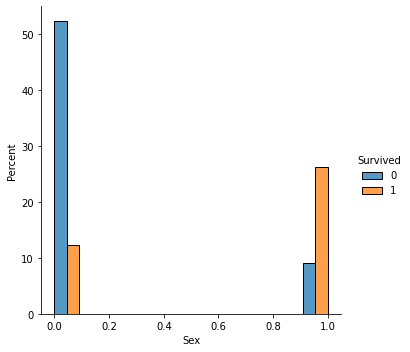

In [7]:
sns.displot(df, x="Sex", hue="Survived", multiple="dodge", kind="hist", stat="percent")

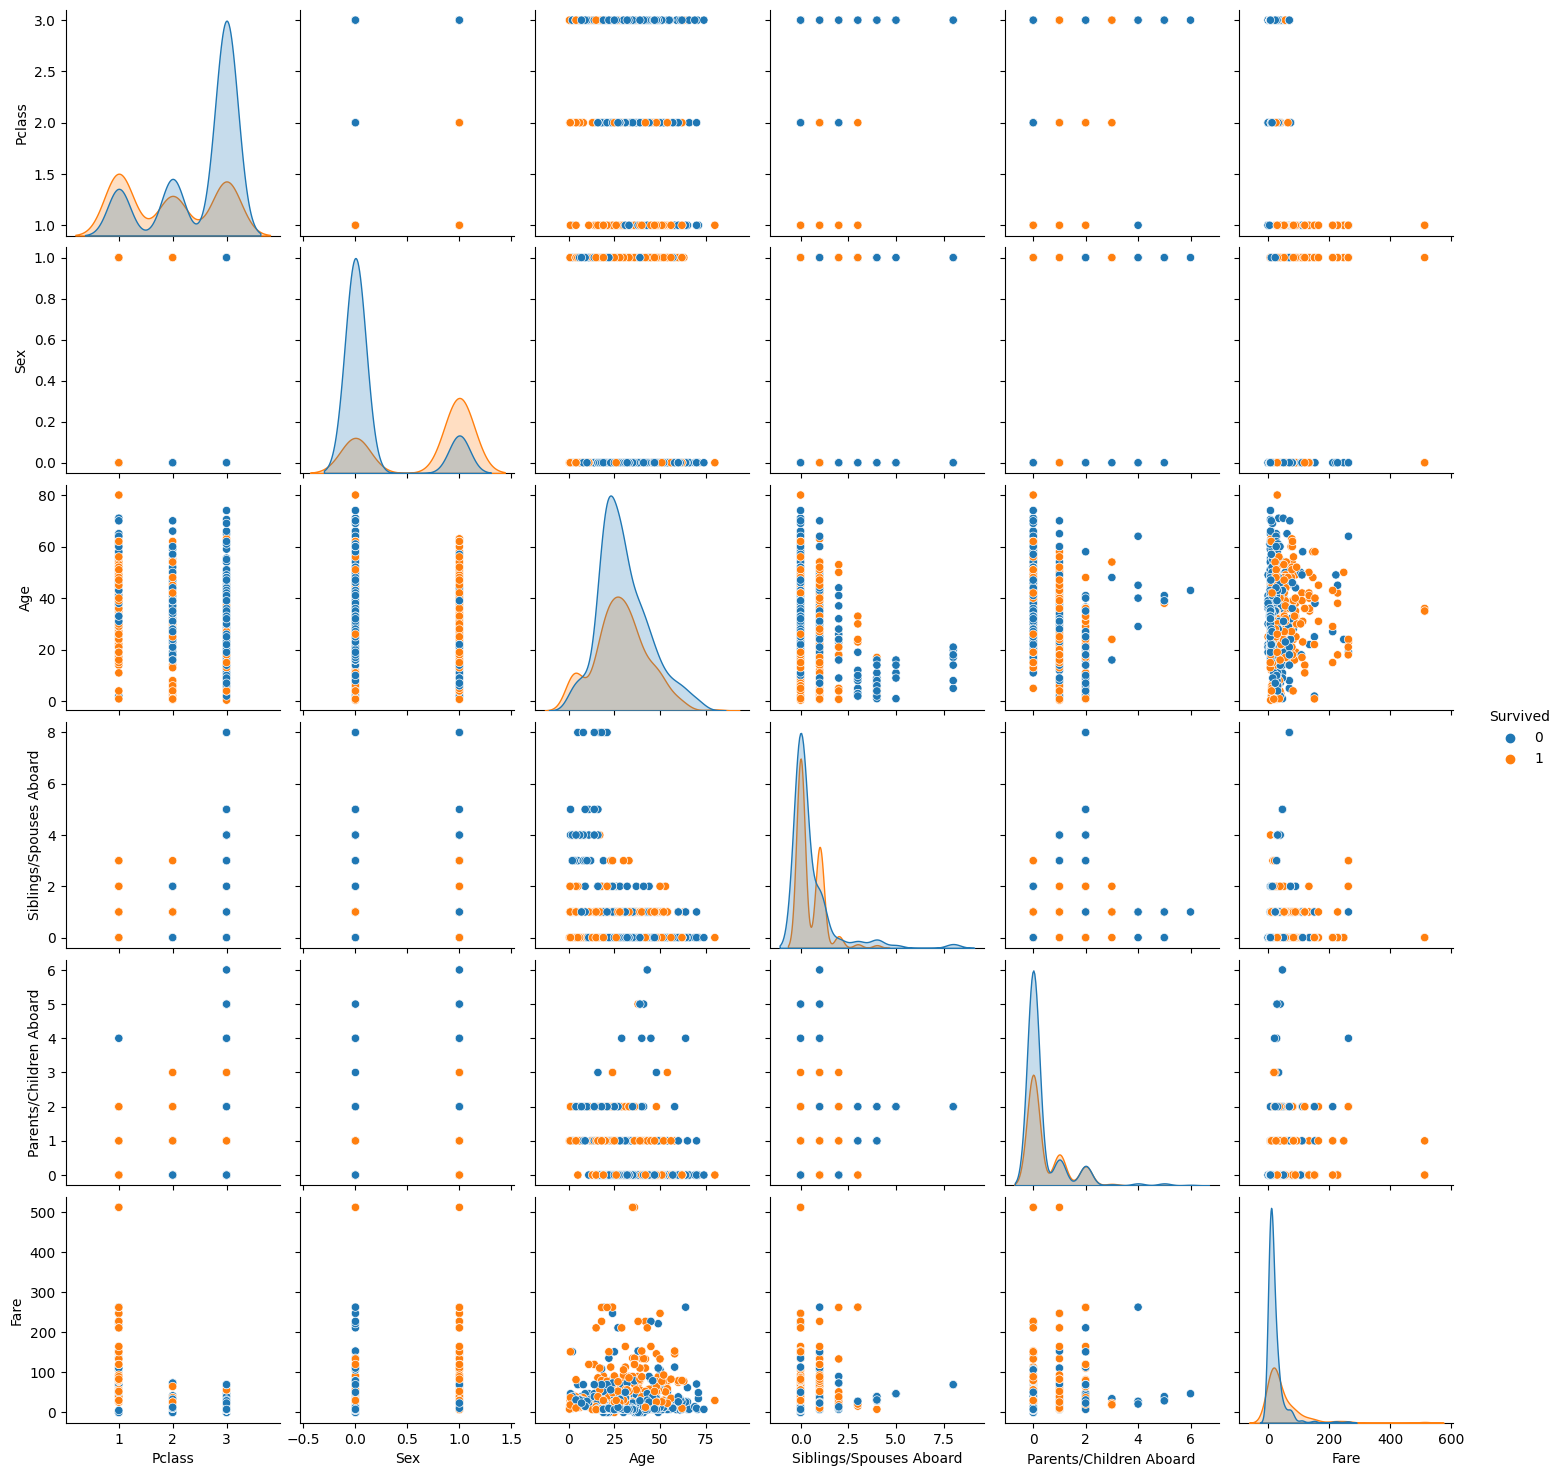

In [8]:
sns.pairplot(df, hue="Survived")

In [9]:
X = df[["Pclass", "Sex", "Age", "Siblings/Spouses Aboard", "Parents/Children Aboard", "Fare"]]
y = df.Survived.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y)

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(X.columns))
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(X.columns))

In [10]:
(X_train.shape, y_train.shape)

((665, 6), (665,))

In [11]:
(X_test.shape, y_test.shape)

((222, 6), (222,))

In [12]:
params = {
    "max_depth": 2,
    "eta": 2,
    "objective": "binary:logistic",
}

bst = xgb.train(params, dtrain, 10)

In [13]:
y_predicted = bst.predict(dtest)

accuracy_score(y_test, y_predicted > 0.5)

0.38288288288288286

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

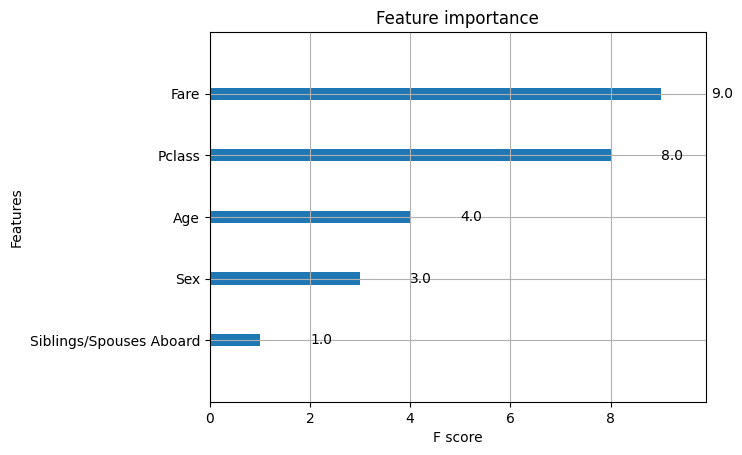

In [14]:
xgb.plot_importance(bst)

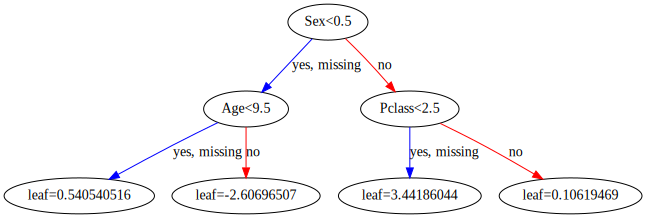

In [15]:
xgb.to_graphviz(bst, num_trees=0)